# Implementation
This notebook implements a simple solver for the steady heat equation, an example of Poisson problem.
\begin{equation}
\left\{
    \begin{array}{ll}
        -\Delta T = f & \mbox{in }\Omega\\
        T=T_D & \mbox{on }\Gamma_D\\
        \frac{\partial T}{\partial \mathbf{n}}=0 & \mbox{on }\Gamma_N
    \end{array}
\right.
\end{equation}

The first block is devoted to the creation of the geometry and the functional space.

For simplicity, we choose the domain to be a unit square $\Omega = [0,1]^2$ and we are using linear finite element for the finite dimensional space onto which the solution is sought.

In [1]:
from mpi4py import MPI
from dolfinx import mesh

N = 50
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)

from dolfinx.fem import FunctionSpace
V = FunctionSpace(domain, ("CG", 1))

## Defining the boundary conditions
On the vertical boundaries ($x=0$ and $x=1$) homogeneous Neumann BCs are imposed, on the top $T=1$ whereas on the bottom $T=0$.

In [2]:
import numpy as np
from petsc4py import PETSc
from dolfinx.fem import dirichletbc, locate_dofs_geometrical, Constant

def bottom(x):
    return np.isclose(x[1], 0.)
def top(x):
    return np.isclose(x[1], 1.)

top_fun = Constant(domain, PETSc.ScalarType(1.))
bot_fun = Constant(domain, PETSc.ScalarType(0.))

bc_top = dirichletbc(top_fun, locate_dofs_geometrical(V, top), V)
bc_bot = dirichletbc(bot_fun, locate_dofs_geometrical(V, bottom), V)
bcs = [bc_top, bc_bot]

## Defining the source term
The source term $f$ is set to be $\sin\left(\pi\,\left[x-\frac{1}{2}\right]\cdot y\right)$

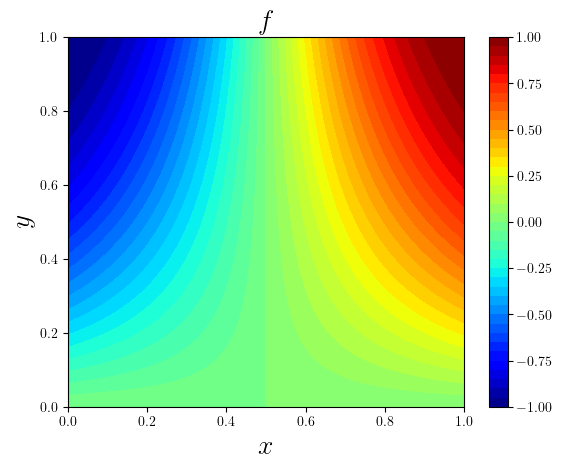

In [3]:
from dolfinx.fem import Function
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

X, Y = np.meshgrid(x,y)
fun = lambda x, y: np.sin(np.pi * (x-0.5) * y)
plt.contourf(X,Y, fun(X,Y), levels = 40, cmap=cm.jet)
plt.xlabel(r'$x$', fontsize = 20)
plt.ylabel(r'$y$', fontsize = 20)
plt.title(r'$f$', fontsize = 20)
plt.colorbar()


f = Function(V)
f.interpolate(lambda x: np.sin(np.pi * (x[0]-0.5) * x[1]))

## Defining the variational problem
As reported before, the Poisson problem should be written in weak form to assemble the matrix of the linear system.

In [4]:
from dolfinx.fem import form
from  dolfinx import fem
from ufl import dot, grad, dx, TrialFunction, TestFunction

T = TrialFunction(V)
v = TestFunction(V)

a = form(dot(grad(T), grad(v)) * dx)
L = form(f * v * dx)

A = fem.petsc.assemble_matrix(a, bcs = bcs)
A.assemble()
b = fem.petsc.assemble_vector(L)

# Apply Dirichlet boundary condition to the vector
fem.petsc.apply_lifting(b, [a], [bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
fem.petsc.set_bc(b, bcs)

## Defining the solver
This simply problem can be solved using both a direct solver (LU factotisation) and an iterative solver (CG is used, since the matrix is symmetric).

In [5]:
lu_solver = PETSc.KSP().create(domain.comm)
lu_solver.setOperators(A)
lu_solver.setType(PETSc.KSP.Type.PREONLY)
lu_solver.getPC().setType(PETSc.PC.Type.LU)

cg_solver = PETSc.KSP().create(domain.comm)
cg_solver.setOperators(A)
cg_solver.setType(PETSc.KSP.Type.CG)
cg_solver.getPC().setType(PETSc.PC.Type.SOR)

## Solving the problem
The solution is computed using the two different approaches

In [6]:
T_lu = Function(V)
T_cg = Function(V)

# Direct solver
lu_solver.solve(b, T_lu.vector)
T_lu.x.scatter_forward()

# Iterative solver
cg_solver.solve(b, T_cg.vector)
T_cg.x.scatter_forward()

## Plotting the solution using matplotlib
The solutions are extracted from the `fem` environment to numpy arrays.

In [7]:
import dolfinx 
from scipy.interpolate import NearestNDInterpolator

x_grid = np.linspace(0., 1., N)
y_grid = np.linspace(0., 1., N)

T_lu_list = []
T_cg_list = []
grid_list = [] 

for ii in range(N):
    points = np.zeros((3, N))
    points[0, :] = x_grid[ii]
    points[1, :] = y_grid

    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    xPlot = np.array(points_on_proc, dtype=np.float64)

    T_lu_list.append(T_lu.eval(xPlot, cells).flatten())
    T_cg_list.append(T_cg.eval(xPlot, cells).flatten())
    grid_list.append(xPlot[:,:2])

T_lu_grid = np.zeros((N * N,  ))
T_cg_grid = np.zeros((N * N,  ))
xy_grid   = np.zeros((N * N, 2))

idx = 0

for ii in range(N):
    for jj in range(N):
        T_lu_grid[idx]  = T_lu_list[ii][jj]
        T_cg_grid[idx]  = T_cg_list[ii][jj]
        xy_grid[idx, 0] = grid_list[ii][jj, 0]
        xy_grid[idx, 1] = grid_list[ii][jj, 1]
        idx += 1

T_lu_fun = NearestNDInterpolator(xy_grid, T_lu_grid)
T_cg_fun = NearestNDInterpolator(xy_grid, T_cg_grid)

All the necessary libraries are imported along with the settings to have latex-style labels.

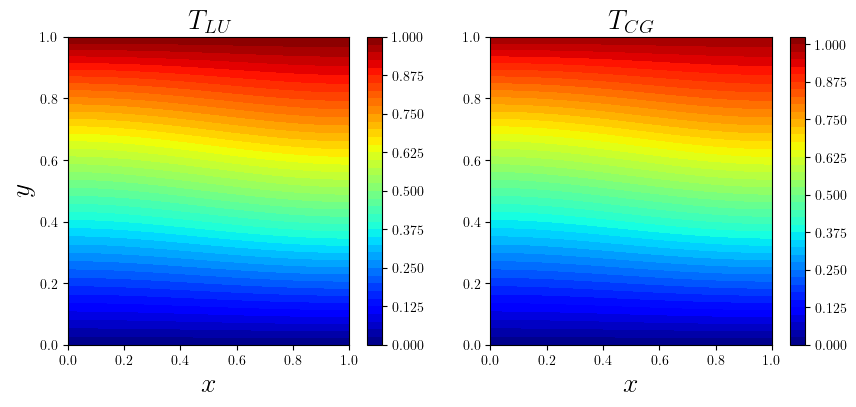

In [11]:
X, Y = np.meshgrid(x_grid, y_grid)

fig = plt.figure( figsize = (10,4) )

plt.subplot(1,2,1)
plt.contourf(X, Y, T_lu_fun(X,Y), cmap=cm.jet, levels = 40)
plt.colorbar()
plt.xlabel(r'$x$', fontsize = 20)
plt.ylabel(r'$y$', fontsize = 20)
plt.title(r'$T_{LU}$', fontsize = 20)

plt.subplot(1,2,2)
plt.contourf(X, Y, T_cg_fun(X,Y), cmap=cm.jet, levels = 40)
plt.colorbar()
plt.xlabel(r'$x$', fontsize = 20)
plt.title(r'$T_{CG}$', fontsize = 20)

fig.savefig('T_Poisson.pdf', format='pdf', dpi=600, bbox_inches='tight')